# Movie Genre Classification

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
#STOPWORDS = set(stopwords.words('english'))
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [12]:
pip install wordcloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/34/ac/72a4e42e76bf549dfd91791a6b10a9832f046c1d48b5e778be9ec012aa47/wordcloud-1.9.2-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/151.4 kB ? eta -:--:--
   ------------- -------------------------- 51.2/151.4 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 151.4/151.4 kB 1.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for plotly from https://files.pythonhosted.org/packages/26/5d/1e13b597ed8e54803e9ac6ded18c04cd35d8cbc49016778ec50c4ca9e9d5/plotly-5.16.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for tenacity>=6.2.0 from https://files.pythonhosted.org/packages/f4/f1/990741d5bb2487d529d20a433210ffa136a367751e454214013b441c4575/tenacity-8.2.3-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
   ---------

In [ ]:
import nltk
nltk.download()

## Loading Data

In [17]:
train_df = pd.read_csv(
    './train_data.txt', 
    sep=" ::: ", 
    names=['id', 'title', 'genre', 'description'], 
    engine='python',
    skipinitialspace = True)

* Here while loading data we are loading it via text file and converting it to dataframe by specifying the separator.
* Second we are assigning names to the columns as we dont already have lables in text file.

In [18]:
train_df.head()

,id,title,genre,description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...


---
## Exploratory Data Analysis

In [19]:
train_df.shape

(54214, 4)

* we have 54214 rows and 4 columns

In [21]:
train_df.isna().sum()

id             0
title          0
genre          0
description    0
dtype: int64

* We dont have any null values in the DataFrame

In [22]:
train_df['genre'].unique()

array(['drama', 'thriller', 'adult', 'documentary', 'comedy', 'crime',
       'reality-tv', 'horror', 'sport', 'animation', 'action', 'fantasy',
       'short', 'sci-fi', 'music', 'adventure', 'talk-show', 'western',
       'family', 'mystery', 'history', 'news', 'biography', 'romance',
       'game-show', 'musical', 'war'], dtype=object)

* We have 27 unique genres in our dataset so we will have to reduce our target classes

---
### Genre Distribution

In [26]:
genre = train_df['genre'].value_counts()
fig = px.bar(genre, x=genre.index, y=genre, title='Genre Distribution')
fig.update_layout(xaxis_title='Genre', yaxis_title='Count')
fig.show()

---
### Histogram of Description Length

In [27]:
train_df['length']=train_df['description'].apply(len)
fig = px.histogram(train_df, x='length', nbins=100, title='Histogram of Length')
fig.update_layout(xaxis_title='Length', yaxis_title='Frequency')
fig.show()

---
### Mean Description Length by Genre

In [29]:
grp_df = train_df.groupby('genre')['length'].mean().reset_index()

fig = px.bar(grp_df, x='genre', y='length', title='Mean Length by Genre')
fig.update_layout(xaxis_title='Genre', yaxis_title='Mean Description Length')

fig.show()

In [31]:
def get_top_n_bigram(text, ngram=1, top=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)

    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]

In [32]:
top_30_unigrams = get_top_n_bigram(train_df.description, ngram=1, top=30)
top_30_bigrams = get_top_n_bigram(train_df.description, ngram=2, top=30)
top_30_trigrams = get_top_n_bigram(train_df.description, ngram=3, top=30)

---
### Top 30 Unigrams

In [33]:
df1 = pd.DataFrame(top_30_unigrams, columns = ['unigram' , 'count'])
fig = px.bar(df1, x='unigram', y='count', title='Top 30 Unigrams', color='unigram')
fig.update_layout(xaxis_title='Unigram', yaxis_title='Count')
fig.update_xaxes(tickangle=80)

fig.show()

---
### Top 30 Bigrams

In [34]:
df1 = pd.DataFrame(top_30_bigrams, columns = ['unigram' , 'count'])
fig = px.bar(df1, x='unigram', y='count', title='Top 30 Unigrams', color='unigram')
fig.update_layout(xaxis_title='Unigram', yaxis_title='Count')
fig.update_xaxes(tickangle=80)

fig.show()

---
### Top 30 Trigrams

In [35]:
df1 = pd.DataFrame(top_30_trigrams, columns = ['unigram' , 'count'])
fig = px.bar(df1, x='unigram', y='count', title='Top 30 Unigrams', color='unigram')
fig.update_layout(xaxis_title='Unigram', yaxis_title='Count')
fig.update_xaxes(tickangle=80)

fig.show()

---
### WordCloud

In [36]:
text_data = ' '.join(train_df['description'])

# Create a WordCloud object
wordcloud = WordCloud(stopwords=STOPWORDS, max_words=40, background_color='white').generate(text_data)

# Display the word cloud using Plotly Express
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

NameError: name 'STOPWORDS' is not defined

---
## Text Cleaning and Lemmitization

In [16]:
nltk.download('punkt')
nltk.download('wordnet')

def clean_text(text):
    # Tokenize the text
    words = word_tokenize(text)
    
    # Initialize stopwords and lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Remove numbers, lowercase words, remove stopwords, and lemmatize
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word.isalpha() and word.lower() not in STOPWORDS]
    
    # Join the cleaned words back into a single string
    cleaned_text = ' '.join(words)
    
    return cleaned_text

[nltk_data] Downloading package punkt to

[nltk_data]     C:\Users\kalya\AppData\Roaming\nltk_data...

[nltk_data]   Package punkt is already up-to-date!

[nltk_data] Downloading package wordnet to

[nltk_data]     C:\Users\kalya\AppData\Roaming\nltk_data...

[nltk_data]   Package wordnet is already up-to-date!


In [17]:
train_df['description_cleaned'] = train_df['description'].apply(clean_text)

---
### WordCloud After Cleaning

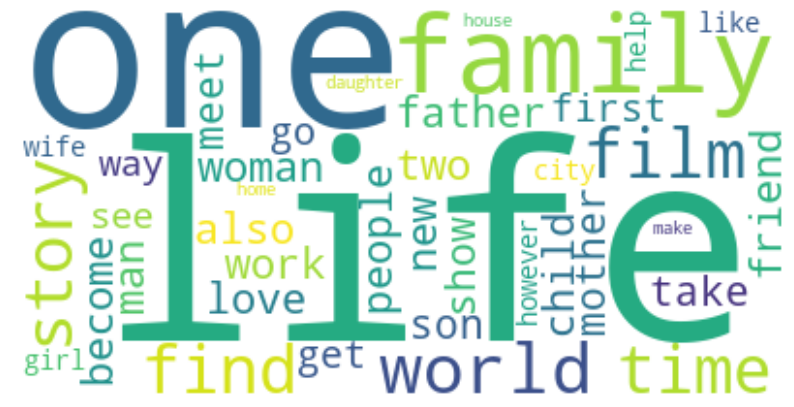

In [18]:
text_data = ' '.join(train_df['description_cleaned'])

wordcloud = WordCloud(stopwords=STOPWORDS, max_words=40, background_color='white').generate(text_data)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

---
### Histogram of Length After Text Cleaning

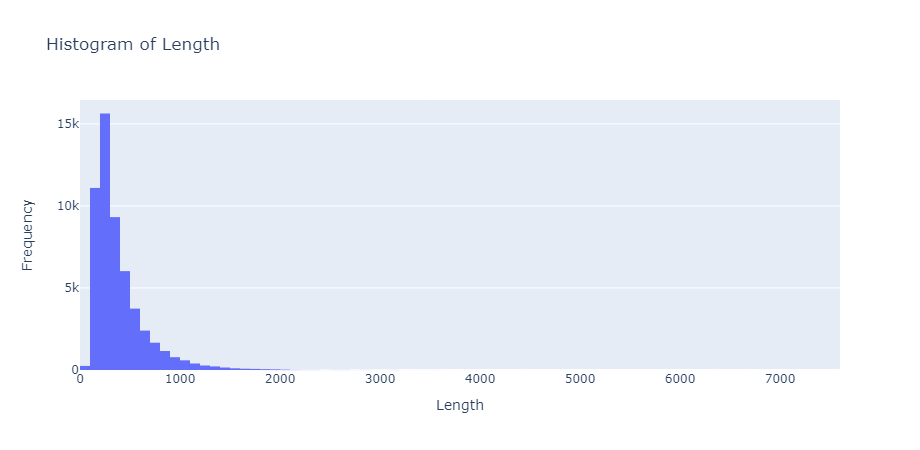

In [19]:
train_df['length_cleaned']=train_df['description_cleaned'].apply(len)
fig = px.histogram(train_df, x='length_cleaned', nbins=100, title='Histogram of Length')
fig.update_layout(xaxis_title='Length', yaxis_title='Frequency')
fig.show()

---
### Mean Description Length by Genre After Cleaning

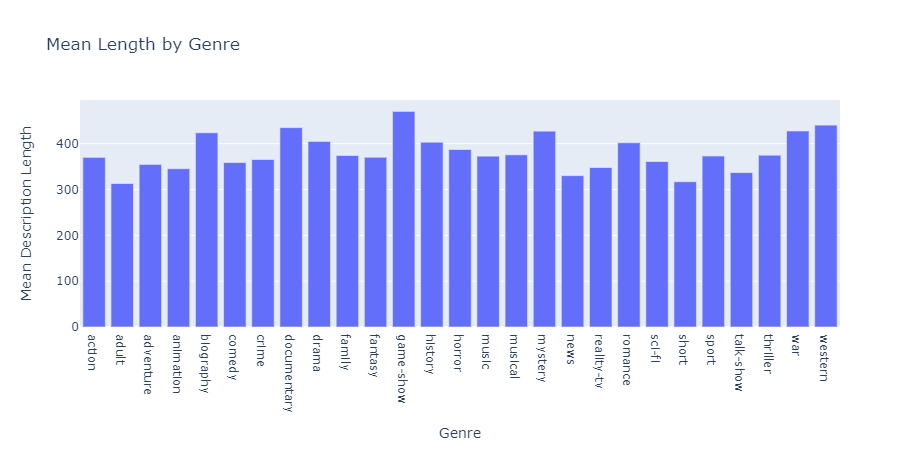

In [20]:
grp_df = train_df.groupby('genre')['length_cleaned'].mean().reset_index()

fig = px.bar(grp_df, x='genre', y='length_cleaned', title='Mean Length by Genre')
fig.update_layout(xaxis_title='Genre', yaxis_title='Mean Description Length')

fig.show()

---
## Merging target Classes in Broader Classes

In [21]:
def make_genre_groups(df):
    df.genre.mask((df['genre'] == "biography") | (df['genre'] == "history"), "documentary", inplace=True)

    df.genre.mask((df['genre'] == "mystery") | (df['genre'] == "horror"), "thriller", inplace=True)

    df.genre.mask((df['genre'] == "adventure") | (df['genre'] == "sci-fi") | (df['genre'] == "fantasy"), 
                  "action", inplace=True)

    df.genre.mask((df['genre'] == "romance"), "comedy", inplace=True)

    df.genre.mask((df['genre'] == "short") | (df['genre'] == "western") | (df['genre'] == "reality-tv") |
                        (df['genre'] == "family") | (df['genre'] == "music") | (df['genre'] == "adult") |
                        (df['genre'] == "crime") | (df['genre'] == "animation") | (df['genre'] == "sport") |
                        (df['genre'] == "talk-show") | (df['genre'] == "musical") | (df['genre'] == "game-show") |
                        (df['genre'] == "news") | (df['genre'] == "war"), "other", inplace=True)
    return df

In [22]:
train_df = make_genre_groups(train_df.copy())

---
### Genre Distribution After Merging

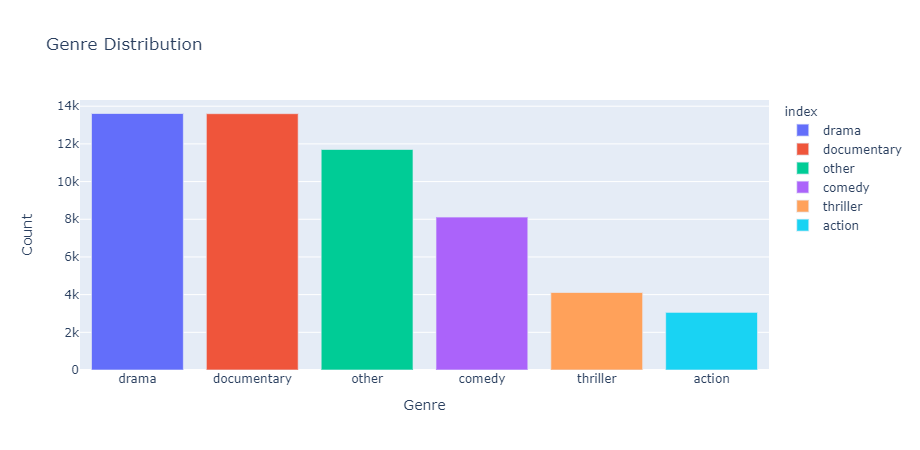

In [23]:
genre = train_df['genre'].value_counts()
fig = px.bar(genre, x=genre.index, y=genre, title='Genre Distribution', color=genre.index)
fig.update_layout(xaxis_title='Genre', yaxis_title='Count')
fig.show()

* After grouping same type of genres together we were able to reduce the genres to 6 classes

In [24]:
train_df.head()

,id,title,genre,description,length,description_cleaned,length_cleaned
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...,545,listening conversation doctor parent oscar lea...,346
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...,183,brother sister past incestuous relationship cu...,117
2,3,"Young, Wild and Wonderful (1980)",other,As the bus empties the students for their fiel...,649,bus empty student field trip museum natural hi...,369
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...,1081,help unemployed father make end meet edith twi...,714
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...,624,film title refers body ground zero also state ...,377


---
## Model Training

### Text Vectorization using TF-IDF

**Convert the raw texts to a matrix of TF-IDF features**

- **max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

- **min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

- **ngram_range** controls the range of consecutive word combinations treated as features during text-to-numerical conversion. ngram_range=(1, 3) means it will include all the unigrams, bigrams and trigrams.

In [25]:
tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, ngram_range=(1, 3), max_features=5000)

In [26]:
tfidf_matrix = tfidf_vectorizer.fit_transform(train_df.description_cleaned) 

In [27]:
tfidf_vectorizer.get_feature_names_out()[:10]

array(['aaron', 'abandon', 'abandoned', 'abducted', 'ability', 'able',
       'aboard', 'abortion', 'abroad', 'absence'], dtype=object)

In [28]:
train_tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

### Label Encoding Target Column

In [29]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_df['genre'])

In [30]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_mapping

{'action': 0,
 'comedy': 1,
 'documentary': 2,
 'drama': 3,
 'other': 4,
 'thriller': 5}

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_tfidf_df, y, test_size=0.2, random_state=42)

In [32]:
from sklearn.metrics import *
def evaluate(test, pred):
    accuracy = accuracy_score(test, pred)
    cf_report = classification_report(test, pred)
    precision = precision_score(test, pred, average='macro')
    recall = recall_score(test, pred, average='macro')
    f1 = f1_score(test, pred, average='macro')
    
    print('Accuracy', accuracy)
    print('Classification Report', cf_report)
    print('Precision', precision)
    print('Recall', recall)
    print('F1-Score', f1)

### Base XGBClassifier

In [33]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [34]:
evaluate(y_test,y_pred)

Accuracy 0.5946693719450337

Classification Report               precision    recall  f1-score   support



           0       0.57      0.27      0.37       619

           1       0.59      0.41      0.48      1594

           2       0.73      0.76      0.74      2765

           3       0.55      0.71      0.62      2697

           4       0.50      0.52      0.51      2372

           5       0.62      0.48      0.54       796



    accuracy                           0.59     10843

   macro avg       0.59      0.52      0.54     10843

weighted avg       0.60      0.59      0.59     10843



Precision 0.5922877222749124

Recall 0.5245799481235142

F1-Score 0.5435623648597857


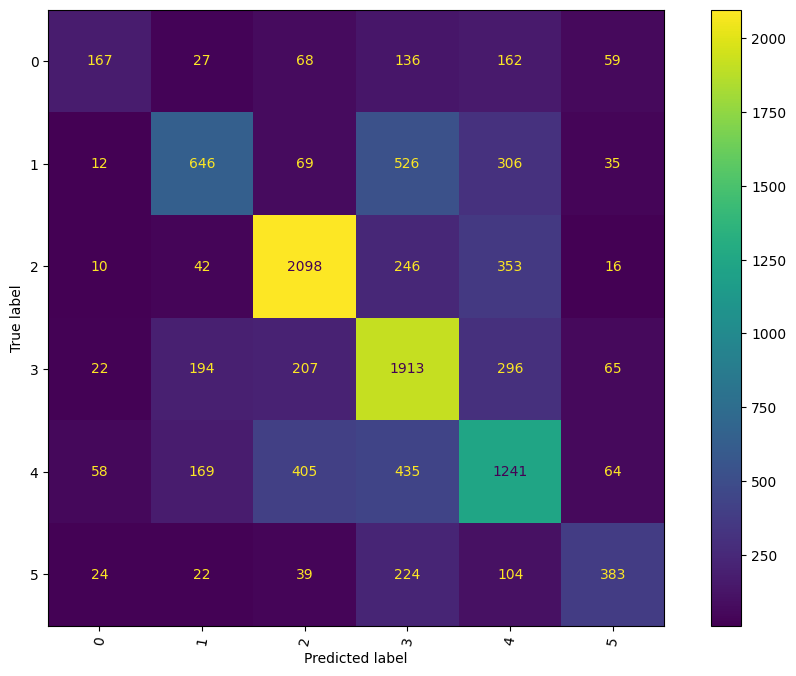

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))
    # Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=xgb_model.classes_)
cmp.plot(ax=ax)
plt.xticks(rotation=80)

plt.show();

### XGBClassifier with Class Weights

In [36]:
from sklearn.utils import class_weight
import numpy as np
class_weights = list(class_weight.compute_class_weight(class_weight='balanced',
                                             classes = np.unique(y),
                                             y = y))

In [37]:
class_weights

[2.9528322440087145,
 1.1129038879993431,
 0.6641919043418603,
 0.6637527853277504,
 0.772015265436318,
 2.196321503808135]

* The utilization of class weights serves as a valuable technique for addressing the class imbalance observed in the aforementioned graph depicting the distribution of movies across different genres.
* This approach assigns varying weights to different classes during the training process of machine learning models.

In [38]:
weights = np.ones(X_train.shape[0], dtype = 'float')

In [39]:
for i, val in enumerate(y_train):
    weights[i] = class_weights[val]

weights

array([0.66375279, 0.66375279, 0.6641919 , ..., 0.66375279, 0.66375279,
       0.6641919 ])

In [41]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train, sample_weight=weights)
cw_y_pred = xgb_model.predict(X_test)

In [42]:
y_train_pred = xgb_model.predict(X_train)

In [43]:
evaluate(y_test, cw_y_pred)

Accuracy 0.581573365304805

Classification Report               precision    recall  f1-score   support



           0       0.34      0.46      0.39       619

           1       0.49      0.52      0.50      1594

           2       0.75      0.73      0.74      2765

           3       0.60      0.57      0.58      2697

           4       0.55      0.47      0.51      2372

           5       0.50      0.65      0.57       796



    accuracy                           0.58     10843

   macro avg       0.54      0.57      0.55     10843

weighted avg       0.59      0.58      0.58     10843



Precision 0.5389641408840856

Recall 0.5672844725207786

F1-Score 0.5493873651506537


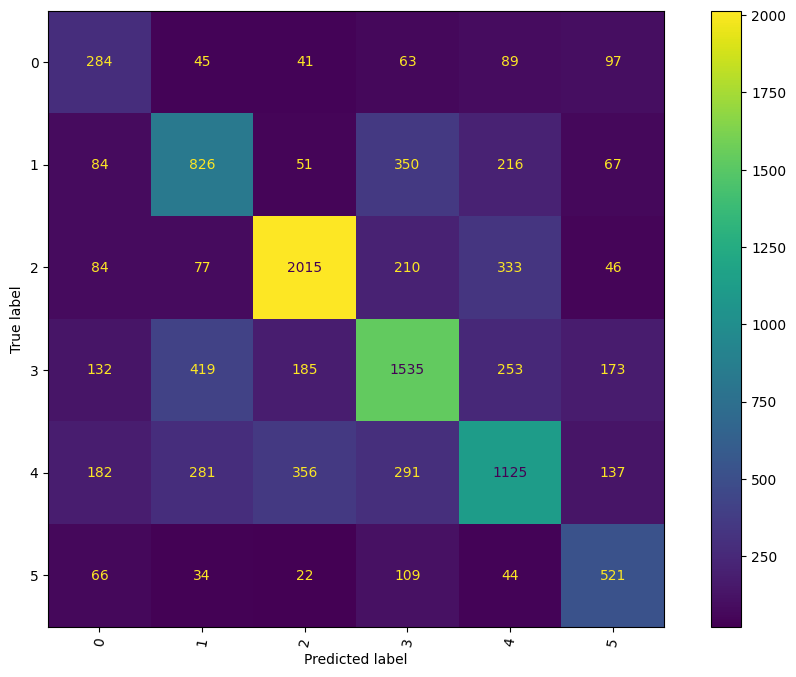

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))
    # Create the confusion matrix
cm = confusion_matrix(y_test, cw_y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=xgb_model.classes_)
cmp.plot(ax=ax)
plt.xticks(rotation=80)

plt.show();

### Linear Regression

In [45]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=42, solver='liblinear')
log_reg.fit(X_train, y_train, sample_weight=weights)

LogisticRegression(random_state=42, solver='liblinear')

In [46]:
lr_pred = log_reg.predict(X_test)
evaluate(y_test, lr_pred)

Accuracy 0.6109010421470072

Classification Report               precision    recall  f1-score   support



           0       0.35      0.57      0.43       619

           1       0.54      0.60      0.57      1594

           2       0.76      0.76      0.76      2765

           3       0.66      0.57      0.61      2697

           4       0.60      0.46      0.52      2372

           5       0.51      0.71      0.59       796



    accuracy                           0.61     10843

   macro avg       0.57      0.61      0.58     10843

weighted avg       0.63      0.61      0.61     10843



Precision 0.5690612721235763

Recall 0.6129322534918987

F1-Score 0.5815151413828382


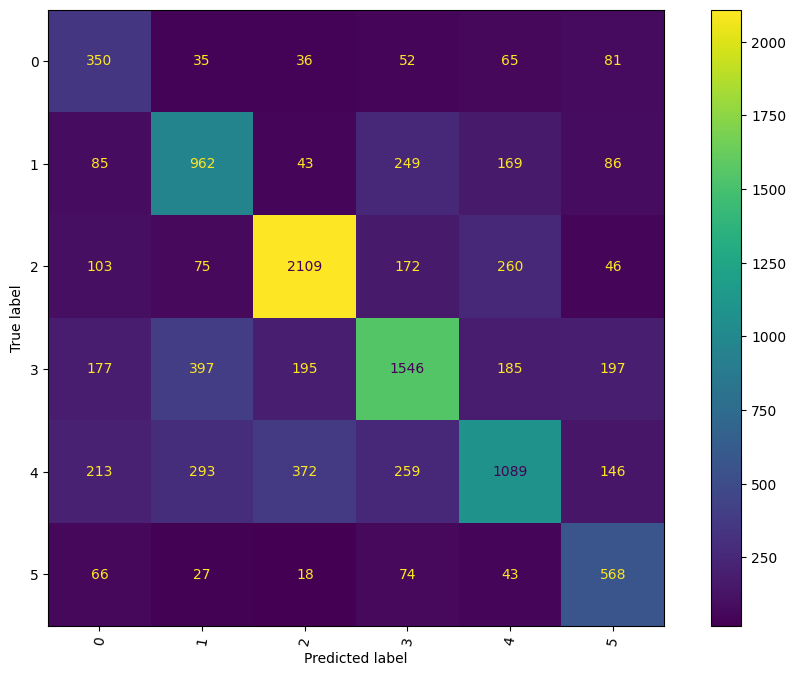

In [47]:
fig, ax = plt.subplots(figsize=(12, 8))
    # Create the confusion matrix
cm = confusion_matrix(y_test, lr_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=xgb_model.classes_)
cmp.plot(ax=ax)
plt.xticks(rotation=80)

plt.show();

### MultinomialNB

In [48]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train, y_train, sample_weight=weights)

MultinomialNB()

In [49]:
mnb_pred = mnb.predict(X_test)
evaluate(y_test, mnb_pred)

Accuracy 0.5861846352485475

Classification Report               precision    recall  f1-score   support



           0       0.35      0.58      0.44       619

           1       0.52      0.56      0.54      1594

           2       0.72      0.77      0.74      2765

           3       0.62      0.58      0.60      2697

           4       0.59      0.36      0.45      2372

           5       0.48      0.70      0.57       796



    accuracy                           0.59     10843

   macro avg       0.55      0.59      0.56     10843

weighted avg       0.60      0.59      0.58     10843



Precision 0.5466747520410113

Recall 0.5923176622076644

F1-Score 0.5565109290449382


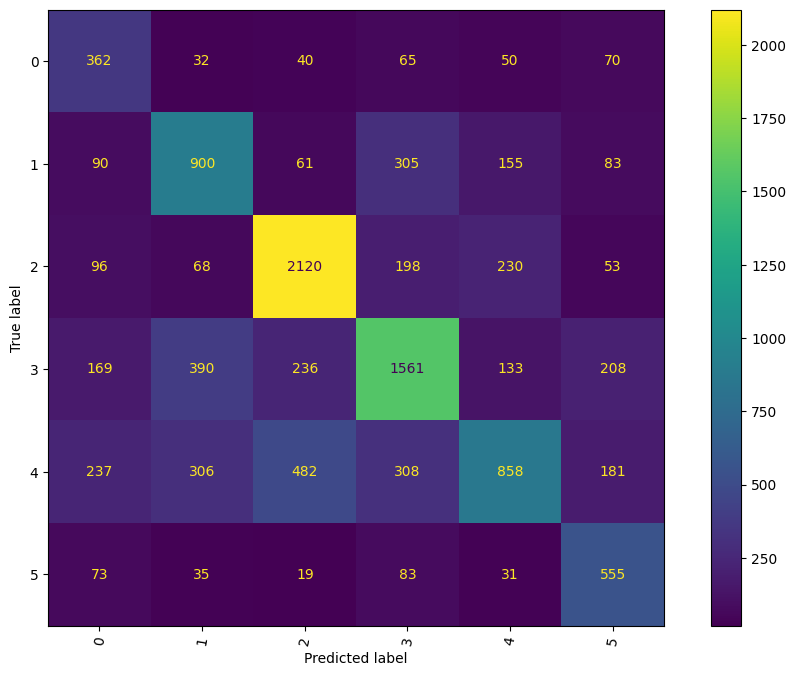

In [50]:
fig, ax = plt.subplots(figsize=(12, 8))
    # Create the confusion matrix
cm = confusion_matrix(y_test, mnb_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=xgb_model.classes_)
cmp.plot(ax=ax)
plt.xticks(rotation=80)

plt.show();

## Conclusion

In conclusion, after evaluating various models for the given task, it is evident that the logistic regression model emerges as the most suitable choice. With an accuracy of 0.61, precision of 0.57, recall of 0.61, and an F1-score of 0.58, the logistic regression model consistently demonstrates balanced performance across multiple evaluation metrics. These results suggest that the model effectively captures the complexities of the data, providing a harmonious trade-off between correct predictions, minimizing false positives, and effectively identifying true positives. Therefore, based on this evaluation, the logistic regression model stands out as the optimal choice for the given multi-class classification task.